# Projeto: Análise de Transações Bancárias e Detecção de Fraude

In [7]:
import pandas as pd

df = pd.read_csv("credit_card_transactions.csv")

# Amostra de 50 mil linhas 
df_sample = df.sample(50000, random_state=42)

df_sample.to_csv(
    "credit_card_transactions_sample.csv",
    index=False
)

In [9]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df["age"] = (pd.to_datetime("today") - pd.to_datetime(df["dob"])).dt.days // 365

In [11]:
print(df.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode', 'age'],
      dtype='object')


In [13]:
df.rename(columns={
    "Unnamed: 0": "id",
    "trans_date_trans_time": "data_transacao",
    "cc_num": "numero_cartao",
    "merchant": "estabelecimento",
    "category": "categoria",
    "amt": "valor_transacao",
    "first": "nome_cliente",
    "last": "sobrenome_cliente",
    "gender": "genero",
    "street": "rua",
    "city": "cidade",
    "state": "estado",
    "zip": "cep_cliente",
    "lat": "latitude_cliente",
    "long": "longitude_cliente",
    "city_pop": "populacao_cidade",
    "job": "profissao",
    "dob": "data_nascimento",
    "trans_num": "numero_transacao",
    "unix_time": "unix_time",
    "merch_lat": "latitude_estabelecimento",
    "merch_long": "longitude_estabelecimento",
    "is_fraud": "eh_fraude",
    "merch_zipcode": "cep_estabelecimento",
    "age": "idade",
    "trans_month": "mes_transacao"
}, inplace=True)

In [16]:
traducao_categoria = {
    "grocery_pos": "Supermercado",
    "gas_transport": "Combustível / Transporte",
    "electronics": "Eletrônicos",
    "food_dining": "Alimentação / Restaurantes",
    "shopping_net": "Compras Online",
    "health_fitness": "Saúde / Fitness",
    "kids_pets": "Infantil / Pets",
    "personal_care": "Cuidados Pessoais",
    "travel": "Viagem",
    "entertainment": "Entretenimento",
    "misc_net": "Diversos Online",
    "misc_pos": "Diversos Presencial",
    "clothing": "Roupas"
}

df["categoria_pt"] = df["categoria"].map(traducao_categoria).fillna(df["categoria"])

## Distribuição de transações por valor

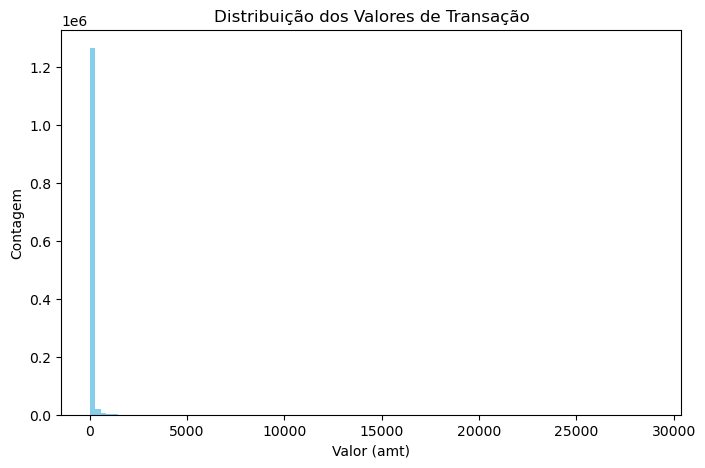

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["valor_transacao"], bins=100, color="skyblue")
plt.title("Distribuição dos Valores de Transação")
plt.xlabel("Valor (amt)")
plt.ylabel("Contagem")

import os
os.makedirs("images", exist_ok=True)

plt.savefig("images/valores_transacao.png", dpi=300, bbox_inches="tight")
plt.show()

## Fraude por gênero

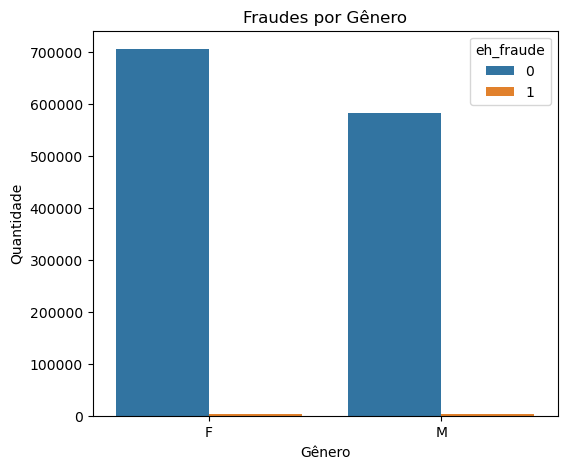

In [22]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.countplot(x="genero", hue="eh_fraude", data=df)
plt.title("Fraudes por Gênero")
plt.xlabel("Gênero")
plt.ylabel("Quantidade")

import os
os.makedirs("images", exist_ok=True)

plt.savefig("images/fraude_por_genero.png", dpi=300, bbox_inches="tight")
plt.show()

## Gastos por mês

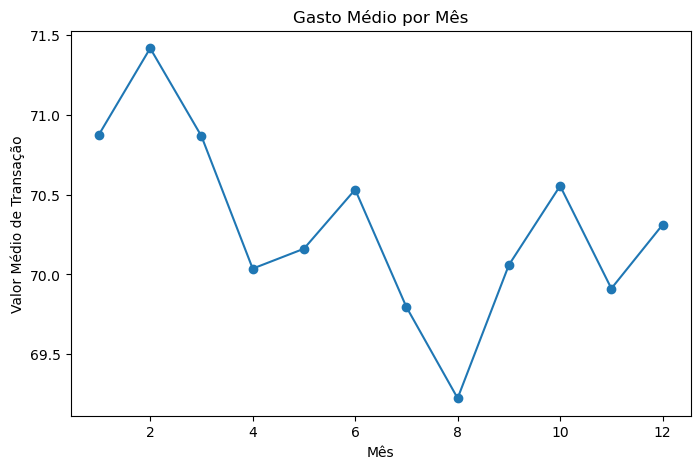

<Figure size 640x480 with 0 Axes>

In [25]:
df["data_transacao"] = pd.to_datetime(df["data_transacao"])
df["mes_transacao"] = df["data_transacao"].dt.month

avg_spend_month = df.groupby("mes_transacao")["valor_transacao"].mean().reset_index()

plt.figure(figsize=(8,5))
plt.plot(avg_spend_month["mes_transacao"], avg_spend_month["valor_transacao"], marker="o")
plt.title("Gasto Médio por Mês")
plt.xlabel("Mês")
plt.ylabel("Valor Médio de Transação")
plt.show()

import os
os.makedirs("images", exist_ok=True)

plt.savefig("images/gasto_medio_mes.png", dpi=300, bbox_inches="tight")
plt.show()

## Top 10 categorias com mais fraudes

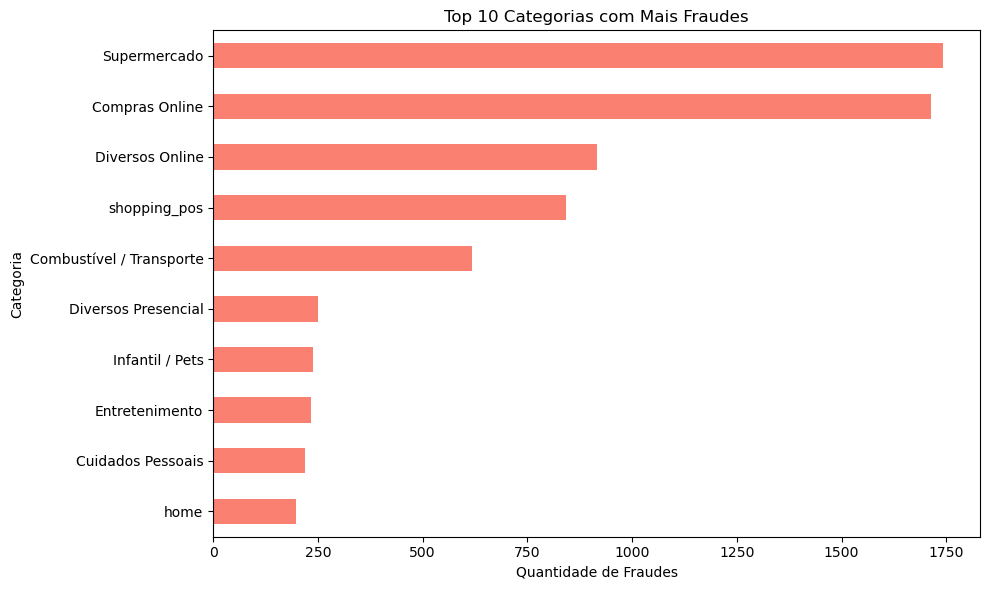

In [28]:
top_categorias_fraude = (
    df[df["eh_fraude"] == 1]
    .groupby("categoria_pt")["eh_fraude"]
    .count()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
top_categorias_fraude.plot(kind="barh", color="salmon")
plt.title("Top 10 Categorias com Mais Fraudes")
plt.xlabel("Quantidade de Fraudes")
plt.ylabel("Categoria")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig("images/top_10_categorias_com_mais_fraudes.png", dpi=300)
plt.show()

## Modelo de Detecção de Fraude (Exemplo)
features simples — valor, mês, idade, gênero e categoria.

In [32]:
df_model = df.copy()

# One-hot para dados categóricos
df_model = pd.get_dummies(
    df_model,
    columns=["genero", "categoria", "estado"],
    drop_first=True
)

features = [
    "valor_transacao", "idade", "mes_transacao"
] + [col for col in df_model.columns if "genero_" in col or "categoria_" in col or "estado_" in col]

X = df_model[features]
y = df_model["eh_fraude"]

In [46]:
X = X.dropna()
y = y.loc[X.index]

In [42]:
X = X.drop(columns=["eh_fraude"])

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, auc

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

y_scores = model.predict_proba(X_test_scaled)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)

print("AUPRC:", auprc)

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    328302
           1       0.09      0.76      0.16      1909

    accuracy                           0.95    330211
   macro avg       0.54      0.86      0.57    330211
weighted avg       0.99      0.95      0.97    330211

AUPRC: 0.1860454736486351
